In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_ta as pta

In [58]:
import warnings
warnings.filterwarnings("ignore")
train = pd.read_csv('hourly_testing_data.csv')#daily_testing_data.csv

In [59]:
results = pd.read_csv('sac_combined_normalized.csv')

In [60]:
capital = 1000000

In [61]:
arr = []
for tic in train["tic"].unique():
    
    df = train.loc[train['tic'] == tic]
    
    
    df.reset_index(drop=True)
    df.set_index('date', inplace=True)
    

    df["sma"] = df["close"].rolling(window=20).mean()
    df["std"] = df["close"].rolling(window=20).std()
    df["upper_band"] = df["sma"] + (df["std"]*2)
    df["lower_band"] = df["sma"] - (df["std"]*2)

    df["Position"] = None
    df["Position"][20:] = np.where(df["close"][20:]<df["lower_band"][20:],1,0)
    df["Position"][20:] = np.where(df["close"][20:]>df["upper_band"][20:],-1,df["Position"][20:])
    df["Bollinger_Returns"] = 1 + (df["close"].pct_change()*df["Position"].shift(1))
    
    x = df["Bollinger_Returns"].cumprod().to_numpy()
    arr.append(x)
bollinger = np.mean(arr, axis=0)

arr = []
ch = []
for tic in train["tic"].unique():
    
    df = train.loc[train['tic'] == tic]
    
    
    df.reset_index(drop=True)
    df.set_index('date', inplace=True)
    

    df["ema12"] = df["close"].ewm(span=12).mean()
    df["ema26"] = df["close"].ewm(span=26).mean()
    df["macd"] = df["ema12"] - df["ema26"]
    df["macd_signal"] = df["macd"].ewm(span=9).mean()
    df["macd_histogram"] = df["macd"] - df["macd_signal"]

    df["regime"] = pd.NA
    for i in range(0, len(df)-1):
        if df["macd_histogram"][i]>= 0:
            df["regime"][i+1]=1
        else:
            df["regime"][i+1]=0

    df["change"] = df["close"].pct_change()+1
    df["MACD_returns"] = 1.0
    for i in range(1, len(df)):
        if df["regime"][i] == 1:
            df["MACD_returns"][i] = df["change"][i]
    
    x = df["MACD_returns"].cumprod().to_numpy()
    c = df["change"].cumprod().to_numpy()
    arr.append(x)
    ch.append(c)
macd = np.mean(arr, axis=0)
buyandhold = np.mean(ch, axis=0)


arr = []
for tic in train["tic"].unique():
    
    df = train.loc[train['tic'] == tic]
    
    
    df.reset_index(drop=True)
    df.set_index('date', inplace=True)
    

    df["rsi"] = pta.rsi(df["close"],2)
    df["rule"] = 0
    z = 1

    for i in range(0, len(df)-1):
        if df["rsi"][i]<= 10 and z ==1:
            df["rule"][i+1]=1
            z = 0
        elif df["rsi"][i]>= 60 and z == 0:
            df["rule"][i] = -1
            z = 1
    for i in range(1, len(df)):
        if df["rule"][i-1] == 1 and df["rule"][i]==0:
            df["rule"][i] = 1
    df["change"] = df["close"].pct_change()+1
    df["RSI_Returns"] = 1.0
    for i in range(0, len(df)):
        if df["rule"][i] != 0:
            df["RSI_Returns"][i] = df["change"][i]
    
    x = df["RSI_Returns"].cumprod().to_numpy()
    arr.append(x)
rsi = np.mean(arr, axis=0)

In [62]:
technical_indicators = pd.DataFrame()
technical_indicator = pd.DataFrame()
technical_indicator["account value"] = buyandhold*capital
technical_indicator["agent"] = "Buy_and_hold"
technical_indicator["date"] = results.date.unique()

In [63]:
technical_indicators = pd.concat([technical_indicators, technical_indicator], ignore_index=True)

In [64]:
technical_indicator = pd.DataFrame()
technical_indicator["account value"] = rsi*capital
technical_indicator["agent"] = "RSI"
technical_indicator["date"] = results.date.unique()

technical_indicators = pd.concat([technical_indicators, technical_indicator], ignore_index=True)


In [65]:
technical_indicator = pd.DataFrame()
technical_indicator["account value"] = bollinger*capital
technical_indicator["agent"] = "Bollinger_bands"
technical_indicator["date"] = results.date.unique()

technical_indicators = pd.concat([technical_indicators, technical_indicator], ignore_index=True)


In [66]:
technical_indicator = pd.DataFrame()
technical_indicator["account value"] = macd*capital
technical_indicator["agent"] = "MACD"
technical_indicator["date"] = results.date.unique()

technical_indicators = pd.concat([technical_indicators, technical_indicator], ignore_index=True)



In [67]:
technical_indicators

,account value,agent,date
0,NaN,Buy_and_hold,2023-04-26 11:00:00
1,1000851.969198,Buy_and_hold,2023-04-26 12:00:00
2,999086.430736,Buy_and_hold,2023-04-26 13:00:00
3,996449.995592,Buy_and_hold,2023-04-26 14:00:00
4,993267.303371,Buy_and_hold,2023-04-26 15:00:00
...,...,...,...
2479,1073513.504294,MACD,2023-08-31 11:00:00
2480,1071876.016305,MACD,2023-08-31 12:00:00
2481,1072349.391525,MACD,2023-08-31 13:00:00
2482,1072479.574481,MACD,2023-08-31 14:00:00


In [68]:
technical_indicators.to_csv('technical_indicators_hourly.csv', index=False)

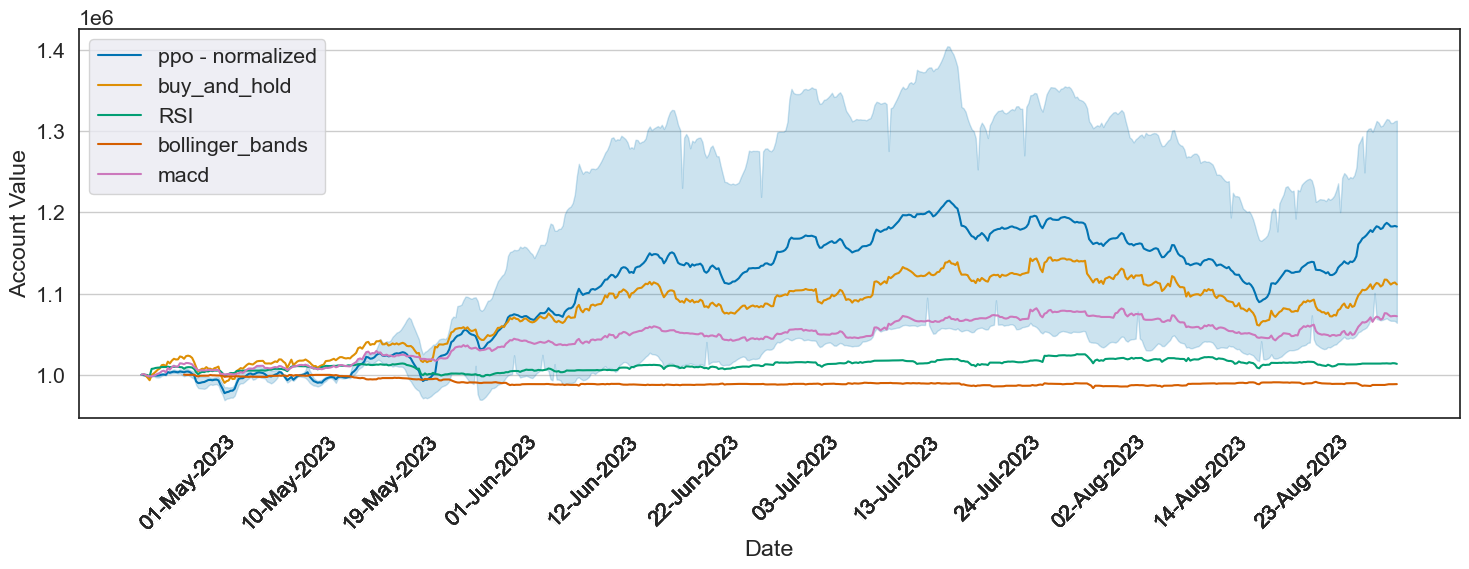

In [24]:
comparison = 'normalized'
agent = 'ppo_a2c'
    # result1 = pd.read_csv('sac_combined_normalized.csv')
    # result2 = pd.read_csv('sac_combined_notNormalized.csv')
result3 = pd.read_csv('result0.csv')
#result4 = pd.read_csv('ppo_combined_notNormalized.csv')
#result5 = pd.read_csv('a2c_combined_normalized.csv')
#result6 = pd.read_csv('a2c_combined_notNormalized.csv')
technical_indicators = pd.read_csv('technical_indicators_hourly.csv')
results = pd.concat([ result3, technical_indicators], ignore_index=True)

    # Ermitteln Sie die Anzahl der Datenpunkte
num_data_points = len(results)

    # Wählen Sie aus, wie viele Ticks Sie anzeigen möchten (z.B. jeden fünften)
num_ticks = 15

    # Berechnen Sie die x-Koordinaten der Ticks
tick_positions = np.arange(0, num_data_points, num_data_points // num_ticks)

    # Plot
    # global
plt.figure(figsize=(15, 6))
sns.set_style("white")
plt.grid(axis='y')

plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=False)

    # dedicated plot
sns.set(font_scale=1.4)
fig2 = sns.lineplot(
        data=results,
        x="date",
        y="account value",
        hue="agent",
        palette="colorblind")
fig2.set(xticklabels=[])
fig2.tick_params(bottom=False)
fig2.set(xlabel="Date")
fig2.set(ylabel="Account Value")

    # ticks
data = pd.to_datetime(results["date"]).copy().dt.strftime('%d-%b-%Y')

    # param to control spacing of labels
n_param = 50

for i in range(len(data)):
    if (i + 1) % n_param:
        data[i] = ""

plt.xticks(results.date, data.values, rotation=45)

    # dedicated plot
plt.legend(loc="upper left")
plt.tight_layout()
    # plt.savefig(f"Compare_agent_performance_{comparison}_{agent}.pdf")
plt.savefig(f"Compare_agents_performance_{comparison}_{agent}.pdf")